# Count and Review

## Arguments

In [1]:
fastqs = '/opt/data/'
# workdir = '/opt/data_out/L25E5M0_workdir/'
workdir = '/opt/data_out/workdir/'
# workdir_new = '/opt/data_out/L25E5M0_workdir_new/'
workdir_new = '/opt/data_out/workdir/'
outdir = '/opt/data_out/L25E5M0_images_new/'

callers = [
    # 'dorado_hac',
    # 'dorado_sup',
    'guppy',
]

datasets = [
    # 'bc3_01',
    # 'bc3_02',
    # 'bc3_03',
    # 'bc6_05',
    # 'bc6_06',
    # 'bc6_07',
    # 'bc6_08',
    # 'bc6_09',
    # 'bc6_10',
    'bc6_2_05',
    'bc6_2_06',
    'bc6_2_07',
    'bc6_2_08',
    'bc6_2_09',
    'bc6_2_10',
    # 'bc7_1_18',
    # 'bc7_1_19',
    # 'bc7_1_20',
    # 'bc7_1_21',
    # 'bc7_1_22',
    # 'bc7_1_23',
    # 'bc7_1_24',
    # 'bc7_2_18',
    # 'bc7_2_19',
    # 'bc7_2_20',
    # 'bc7_2_21',
    # 'bc7_2_22',
    # 'bc7_2_23',
    # 'bc7_2_24',
    # 'sca8_1_11',
    # 'sca8_1_12',
    # 'sca8_1_15',
    # 'sca8_1_16',
    # 'sca8_1_19',
    # 'sca8_1_20',
    # 'sca8_2_11',
    # 'sca8_2_12',
    # 'sca8_2_15',
    # 'sca8_2_16',
    # 'sca8_2_19',
    # 'sca8_2_20',
]

## Imports

In [2]:
import gzip
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import pandas as pd
import seaborn as sns

import common

## Functions

In [3]:
def read_fastq(fastq_path):
    fastq_name = fastq_path.split('/')[-1]
    gzipped = fastq_name.endswith('.gz')
    openner = gzip.open if gzipped else open

    reads = []

    if not isfile(fastq_path):
        return reads

    with openner(fastq_path, 'rt') as f:
        for i, line in enumerate(f):
            line = line.strip()
            if i%4 == 0:
                if line.startswith('@'):
                    id = line.split(' ')[0]
                else:
                    print(f'Error in {fastq_path} line {i} - not an ID line')
                    raise
            elif i%4 == 1:
                seq = line
            elif i%4 == 2:
                if line.startswith('+'):
                    opt = line
                else:
                    print(f'Error in {fastq_path} line {i} - not a + line')
                    raise
            elif i%4 == 3:
                qual = line
                fwd = (len(seq.split('CAGCAG')) - 1) * 2
                rev = (len(seq.split('CTGCTG')) - 1) * 2
                reads.append({
                    'id': id,
                    'seq': seq,
                    'opt': opt,
                    'qual': qual,
                    'fwd': fwd,
                    'rev': rev,
                })

    return reads


def count_reads(input_path):
    tot = 0
    fwd = 0
    rev = 0
    fwd_50 = 0
    fwd_51 = 0
    rev_50 = 0
    rev_51 = 0
    try:
        fastq_paths = sorted(join(input_path, f) for f in listdir(input_path) if 'fastq' in f and isfile(join(input_path, f)))
    except FileNotFoundError:
        return {
            'fastqs': -1,
            'reads': -1,
        }

    for fastq_path in fastq_paths:
        reads = read_fastq(fastq_path)
        tot += len(reads)
        for read in reads:
            if read['fwd'] > read['rev']:
                fwd += 1
                if read['fwd'] > 50:
                    fwd_51 += 1
                elif read['fwd'] > 3:
                    fwd_50 += 1
            elif read['fwd'] < read['rev']:
                rev += 1
                if read['rev'] > 50:
                    rev_51 += 1
                elif read['rev'] > 3:
                    rev_50 += 1


    return {
        'fastqs': len(fastq_paths),
        'reads': tot,
        'fwd': fwd,
        'rev': rev,
        'fwd_50': fwd_50,
        'fwd_51': fwd_51,
        'rev_50': rev_50,
        'rev_51': rev_51,
    }


def count_prepared(input_path):
    df = common.load_tsv(input_path, common.COLUMNS_PREPARED)
    fwd = sum(df['direction'] == 'fwd')
    rev = sum(df['direction'] == 'rev')
    tot = fwd + rev

    cond_fwd = df['direction'] == 'fwd'
    cond_50 = df['ins'].str.len() <= 150

    fwd_50_tot = sum(cond_fwd & cond_50)
    fwd_51_tot = sum(cond_fwd & ~cond_50)
    rev_50_tot = sum(~cond_fwd & cond_50)
    rev_51_tot = sum(~cond_fwd & ~cond_50)
    
    return {
        'prepared_fwd': fwd,
        'prepared_rev': rev,
        'prepared_tot': tot,
        'prepared_fwd_50': fwd_50_tot,
        'prepared_fwd_51': fwd_51_tot,
        'prepared_rev_50': rev_50_tot,
        'prepared_rev_51': rev_51_tot,
    }


def count_processed(input_path):
    df = common.load_tsv(input_path)
    fwd = sum(df['direction'] == 'fwd')
    rev = sum(df['direction'] == 'rev')
    tot = fwd + rev

    cond_fwd = df['direction'] == 'fwd'
    cond_50 = df['len_ins_ext_aln'] <= 150

    fwd_50_tot = sum(cond_fwd & cond_50)
    fwd_51_tot = sum(cond_fwd & ~cond_50)
    rev_50_tot = sum(~cond_fwd & cond_50)
    rev_51_tot = sum(~cond_fwd & ~cond_50)
    
    # fwd_50_med = sum(cond_fwd & cond_50)
    # fwd_51_med = sum(cond_fwd & ~cond_50)
    # rev_50_med = sum(~cond_fwd & cond_50)
    # rev_51_med = sum(~cond_fwd & ~cond_50)

    return {
        'processed_fwd': fwd,
        'processed_rev': rev,
        'processed_tot': tot,
        'processed_fwd_50': fwd_50_tot,
        'processed_fwd_51': fwd_51_tot,
        'processed_rev_50': rev_50_tot,
        'processed_rev_51': rev_51_tot,
    }


def plot_histogram(df, x, hue, base, output_histogram):
    fig, ax = plt.subplots(figsize=(16, 10))
    gfg = sns.histplot(df, x=x, discrete=True, hue=hue, multiple='stack')
    # gfg.set_xlim(0, 1000)
    # gfg.set_yscale("log")
    loc = plticker.MultipleLocator(base=base)
    gfg.xaxis.set_major_locator(loc)
    gfg.set_xticklabels(gfg.get_xticklabels(), rotation=90)
    fig.savefig(output_histogram)


def plot_histograms(df, x, output_path):
    df[x] = df[x] / 3
    cond = df[x] <= 50
    if len(df[cond]) > 0:
        plot_histogram(df[cond].sort_values('direction', ascending=False), x, 'direction', 5, f'{output_path}.hist.50.png')
    cond = df[x] > 50
    if len(df[cond]) > 0:
        plot_histogram(df[cond].sort_values('direction', ascending=False), x, 'direction', 10, f'{output_path}.hist.51.png')


def plot(dataset, caller):
    input_path = f'{workdir_new}{dataset}.{caller}.ontarget.processed.tsv'
    output_path = f'{outdir}{dataset}.{caller}'
    df = pd.read_csv(input_path, sep='\t')
    # for col in common.COLUMNS_LEN:
    #     plot_histograms(df, col, output_path)
    plot_histograms(df, 'len_ins_ext_aln', output_path)

## Main

In [4]:
res = []

for caller in callers:
    for dataset in datasets:
        input_path = f'{workdir}{dataset}.{caller}.ontarget.tsv'
        if not isfile(input_path):
            print(f'Skipping: {dataset}.{caller}')
            continue

        dict_info = {
            'dataset': dataset,
            'caller': caller,
        }

        input_path = f'{fastqs}{dataset}/fastq/{caller}/'
        dict_reads = count_reads(input_path)
        
        input_path = f'{workdir}{dataset}.{caller}.ontarget.tsv'
        dict_ontarget = count_prepared(input_path)
        
        input_path = f'{workdir_new}{dataset}.{caller}.ontarget.processed.tsv'
        dict_processed = count_processed(input_path)

        # plot(dataset, caller)

        # if 'sca' in dataset:
        #     output_path = f'{workdir}images/{dataset}.{caller}.1wtp.'
        #     common.plot_range(input_path, 'ins_aln', 1, 42*3+1, output_path)
        #     output_path = f'{workdir}images/{dataset}.{caller}.2pre.'
        #     common.plot_range(input_path, 'ins_aln', 42*3+1, 74*3+1, output_path)
        #     output_path = f'{workdir}images/{dataset}.{caller}.3mut.'
        #     common.plot_range(input_path, 'ins_aln', 74*3+1, 3001, output_path)
        # else:
        #     output_path = f'{workdir}images/{dataset}.{caller}.1wtp.'
        #     common.plot_range(input_path, 'ins_aln', 1, 37*3+1, output_path)
        #     output_path = f'{workdir}images/{dataset}.{caller}.2pre.'
        #     common.plot_range(input_path, 'ins_aln', 37*3+1, 50*3+1, output_path)
        #     output_path = f'{workdir}images/{dataset}.{caller}.3mut.'
        #     common.plot_range(input_path, 'ins_aln', 50*3+1, 3001, output_path)

        res.append({
            **dict_info,
            **dict_reads,
            **dict_ontarget,
            **dict_processed,
        })

In [5]:
df = pd.DataFrame(res)

In [6]:
df

,dataset,caller,fastqs,reads,fwd,rev,fwd_50,fwd_51,rev_50,rev_51,...,prepared_fwd_51,prepared_rev_50,prepared_rev_51,processed_fwd,processed_rev,processed_tot,processed_fwd_50,processed_fwd_51,processed_rev_50,processed_rev_51
0,bc6_2_05,guppy,25,12692,5327,5176,4703,186,4448,271,...,211,2607,242,3202,2849,6051,2991,211,2607,242
1,bc6_2_06,guppy,24,4929,1845,1992,1646,4,1781,10,...,6,72,10,77,82,159,71,6,72,10
2,bc6_2_07,guppy,25,12932,4842,4664,4232,65,4004,114,...,76,2122,106,2545,2228,4773,2469,76,2122,106
3,bc6_2_08,guppy,24,9789,3992,3943,3303,297,3158,446,...,359,1418,400,1896,1818,3714,1537,359,1418,400
4,bc6_2_09,guppy,24,12000,4641,4288,4075,22,3772,29,...,28,1951,26,2256,1977,4233,2228,28,1951,26
5,bc6_2_10,guppy,24,12979,4982,4789,3977,387,3645,670,...,476,1827,586,2560,2413,4973,2084,476,1827,586


In [7]:
df['freq_prepared'] = df['prepared_tot'] / df['reads']
df['freq_prepared_fwd'] = df['prepared_fwd'] / df['prepared_tot']
df['freq_prepared_rev'] = df['prepared_rev'] / df['prepared_tot']
df['freq_processed_fwd'] = df['processed_fwd'] / df['processed_tot']
df['freq_processed_rev'] = df['processed_rev'] / df['processed_tot']
df.set_index(['dataset', 'caller'])

,,fastqs,reads,fwd,rev,fwd_50,fwd_51,rev_50,rev_51,prepared_fwd,prepared_rev,...,processed_tot,processed_fwd_50,processed_fwd_51,processed_rev_50,processed_rev_51,freq_prepared,freq_prepared_fwd,freq_prepared_rev,freq_processed_fwd,freq_processed_rev
dataset,caller,,,,,,,,,,,,,,,,,,,,,
bc6_2_05,guppy,25,12692,5327,5176,4703,186,4448,271,3202,2849,...,6051,2991,211,2607,242,0.476757,0.529169,0.470831,0.529169,0.470831
bc6_2_06,guppy,24,4929,1845,1992,1646,4,1781,10,77,82,...,159,71,6,72,10,0.032258,0.484277,0.515723,0.484277,0.515723
bc6_2_07,guppy,25,12932,4842,4664,4232,65,4004,114,2545,2228,...,4773,2469,76,2122,106,0.369084,0.533208,0.466792,0.533208,0.466792
bc6_2_08,guppy,24,9789,3992,3943,3303,297,3158,446,1896,1818,...,3714,1537,359,1418,400,0.379405,0.510501,0.489499,0.510501,0.489499
bc6_2_09,guppy,24,12000,4641,4288,4075,22,3772,29,2256,1977,...,4233,2228,28,1951,26,0.352750,0.532955,0.467045,0.532955,0.467045
bc6_2_10,guppy,24,12979,4982,4789,3977,387,3645,670,2560,2413,...,4973,2084,476,1827,586,0.383157,0.514780,0.485220,0.514780,0.485220


<Axes: xlabel='freq_prepared', ylabel='dataset'>

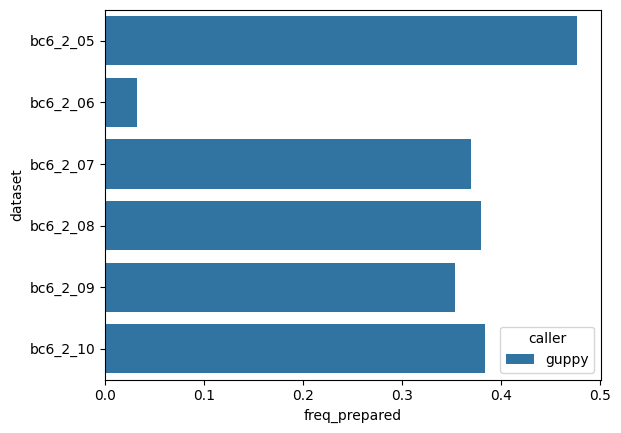

In [8]:
sns.barplot(df, y="dataset", x="freq_prepared", estimator="sum", errorbar=None, hue="caller")

<Axes: xlabel='freq_prepared_fwd', ylabel='dataset'>

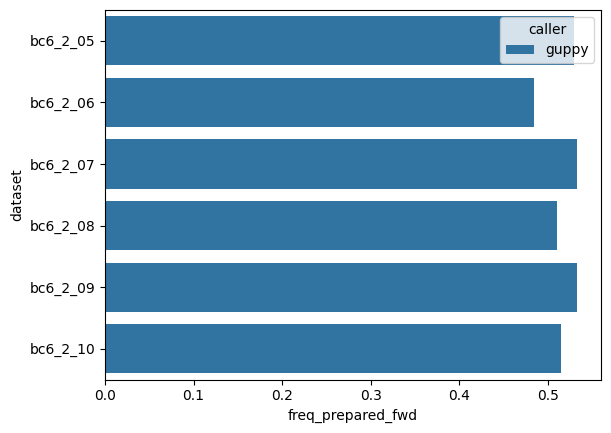

In [9]:
sns.barplot(df, y="dataset", x="freq_prepared_fwd", estimator="sum", errorbar=None, hue="caller")

<Axes: xlabel='freq_prepared_rev', ylabel='dataset'>

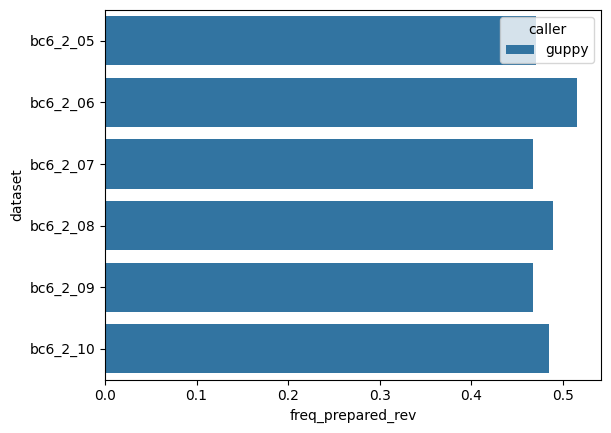

In [10]:
sns.barplot(df, y="dataset", x="freq_prepared_rev", estimator="sum", errorbar=None, hue="caller")

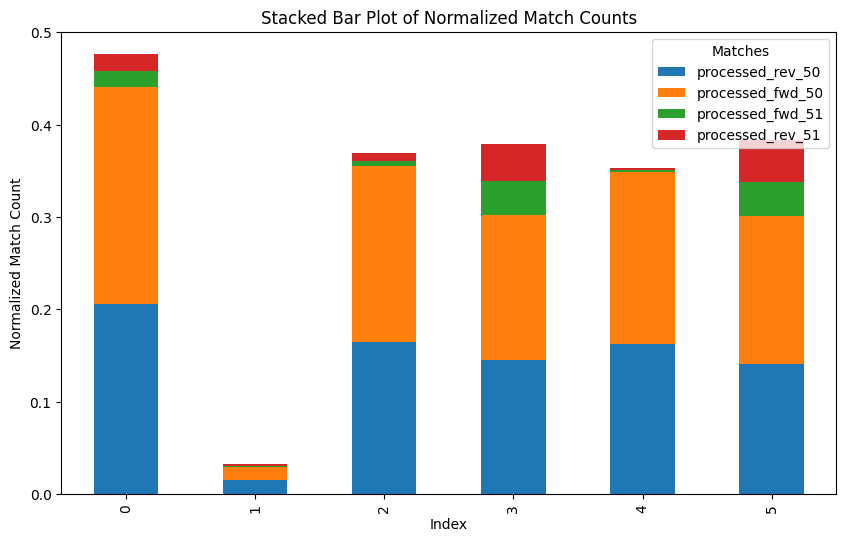

In [11]:
df_normalized = df[[
    'processed_rev_50',
    'processed_fwd_50',
    'processed_fwd_51',
    'processed_rev_51',
]].div(df['reads'], axis=0)

# Plotting
df_normalized.plot(kind='bar', stacked=True, figsize=(10, 6))

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Normalized Match Count')
plt.title('Stacked Bar Plot of Normalized Match Counts')
plt.legend(title='Matches')

# Show plot
plt.show()

## Flanks

In [12]:
common.rev_comp('CTTCATGTTAGAAAACCTGGCTTTA', common.COMPLEMENT)

'TAAAGCCAGGTTTTCTAACATGAAG'

In [13]:
common.rev_comp('CATTTTTTAAAAATATATTATCTTA', common.COMPLEMENT)
# Cattttttaaaaatatattatctta
# CATTTTTTAAAAATATATTATCTTA

'TAAGATAATATATTTTTAAAAAATG'

In [14]:
stop

NameError: name 'stop' is not defined

## Develop waterfall plot

In [15]:
def plot_waterfall(df, col_len, col_seq, stretch, grid, output_path):
    width = min(1500, df[col_len].max())
    
    cond = df['direction'] == 'fwd'
    fwd = df[cond][[col_seq, col_len]].sort_values([col_len, col_seq], ascending=[True, True]).reset_index()

    cond = df['direction'] == 'rev'
    rev = df[cond][[col_seq, col_len]].sort_values([col_len, col_seq], ascending=[False, False]).reset_index()

    fwd = list(fwd[col_seq])
    rev = list(rev[col_seq])
    inss = fwd + [width*'I'] + rev

    width = (width)*stretch+stretch
    height = len(inss)
    image = common.Image.new('RGB', (width, height), 'grey')
    draw = common.ImageDraw.Draw(image)
    bottom = 0
    for i, seq in enumerate(inss):
        y = i
        for j, n in enumerate(reversed(seq)):
        # for j, n in enumerate(seq):
            x = j + 1
            N = 'GAC'[j%3]
            if n == N:
                color = 'black'
            else:
                color = common.COLORS[n]
            draw.line([(stretch*x, y), (stretch*x, y+1)], width=stretch, fill=color)

    for i in range(width):
        y = stretch*i+stretch//2
        if i % 3 == 0:
            draw.line([(y, 0), (y, height)], width=grid, fill='#AAAAAA')
    
        if i % 30 == 0:
            draw.line([(y, 0), (y, height)], width=grid, fill='white')

        if i % 300 == 0:
            draw.line([(y, 0), (y, height)], width=grid, fill='black')

    image.save(output_path)


def plot_waterfalls(dataset, caller):
    input_path = f'{workdir_new}{dataset}.{caller}.ontarget.processed.tsv'
    df = pd.read_csv(input_path, sep='\t')
    col_seq = 'ins_ext_aln'
    col_len = 'len_' + col_seq

    cond = df[col_len] <= 150
    if len(df[cond]) > 0:
        df_sampled = df[cond]
        if len(df[cond]) > 1000:
            df_sampled = df[cond].sample(n=1000, random_state=42)
        output_path = f'{outdir}{dataset}.{caller}.wtrf.50.png'
        plot_waterfall(df_sampled, col_len, col_seq, 15, 2, output_path)

    cond = df[col_len] > 150
    if len(df[cond]) > 0:
        df_sampled = df[cond]
        if len(df[cond]) > 1000:
            df_sampled = df[cond].sample(n=1000, random_state=42)
        output_path = f'{outdir}{dataset}.{caller}.wtrf.51.png'
        plot_waterfall(df_sampled, col_len, col_seq, 7, 1, output_path)

/tmp/ipykernel_363/3728995130.py:152: UserWarning: FixedFormatter should only be used together with FixedLocator
  gfg.set_xticklabels(gfg.get_xticklabels(), rotation=90)
/tmp/ipykernel_363/3728995130.py:152: UserWarning: FixedFormatter should only be used together with FixedLocator
  gfg.set_xticklabels(gfg.get_xticklabels(), rotation=90)
/tmp/ipykernel_363/3728995130.py:152: UserWarning: FixedFormatter should only be used together with FixedLocator
  gfg.set_xticklabels(gfg.get_xticklabels(), rotation=90)
/tmp/ipykernel_363/3728995130.py:152: UserWarning: FixedFormatter should only be used together with FixedLocator
  gfg.set_xticklabels(gfg.get_xticklabels(), rotation=90)
/tmp/ipykernel_363/3728995130.py:152: UserWarning: FixedFormatter should only be used together with FixedLocator
  gfg.set_xticklabels(gfg.get_xticklabels(), rotation=90)
/tmp/ipykernel_363/3728995130.py:152: UserWarning: FixedFormatter should only be used together with FixedLocator
  gfg.set_xticklabels(gfg.get_xt

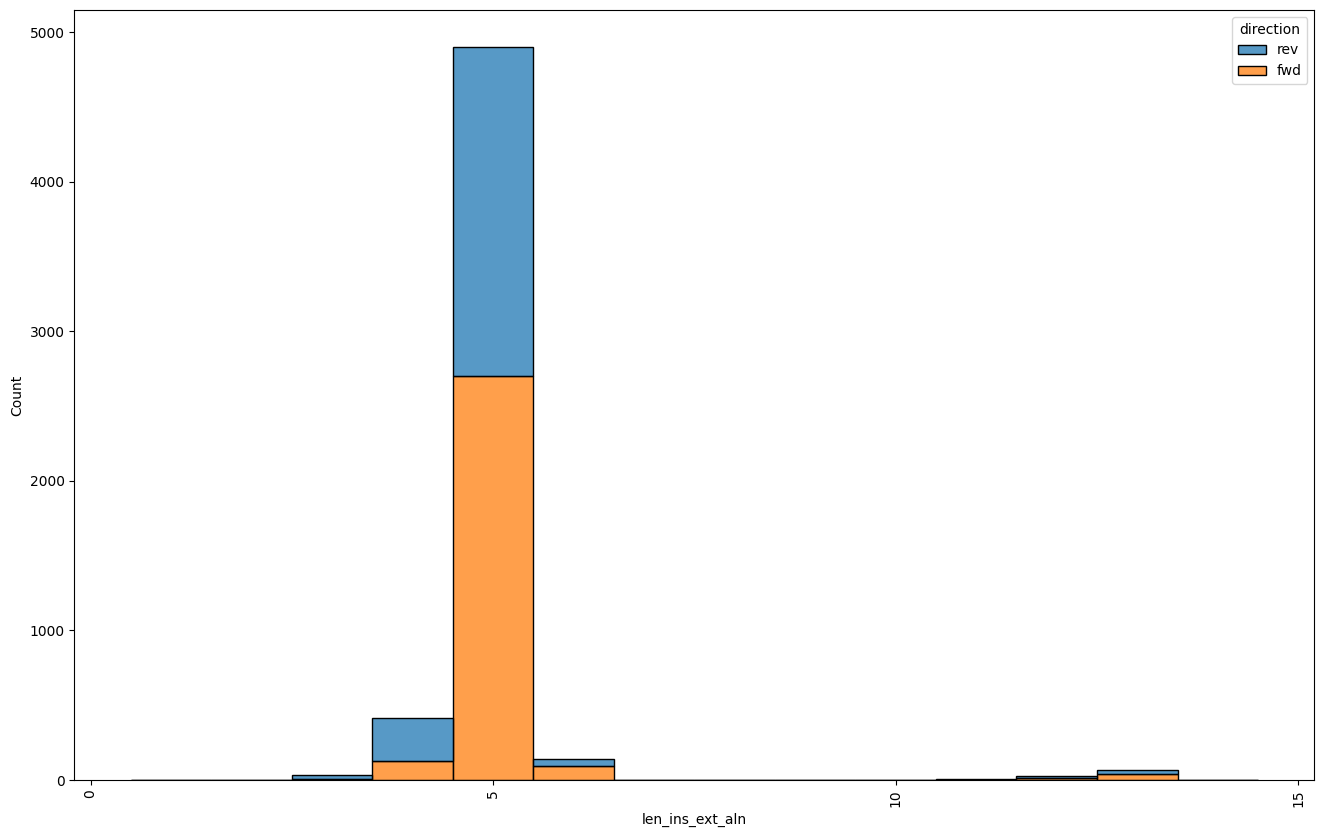

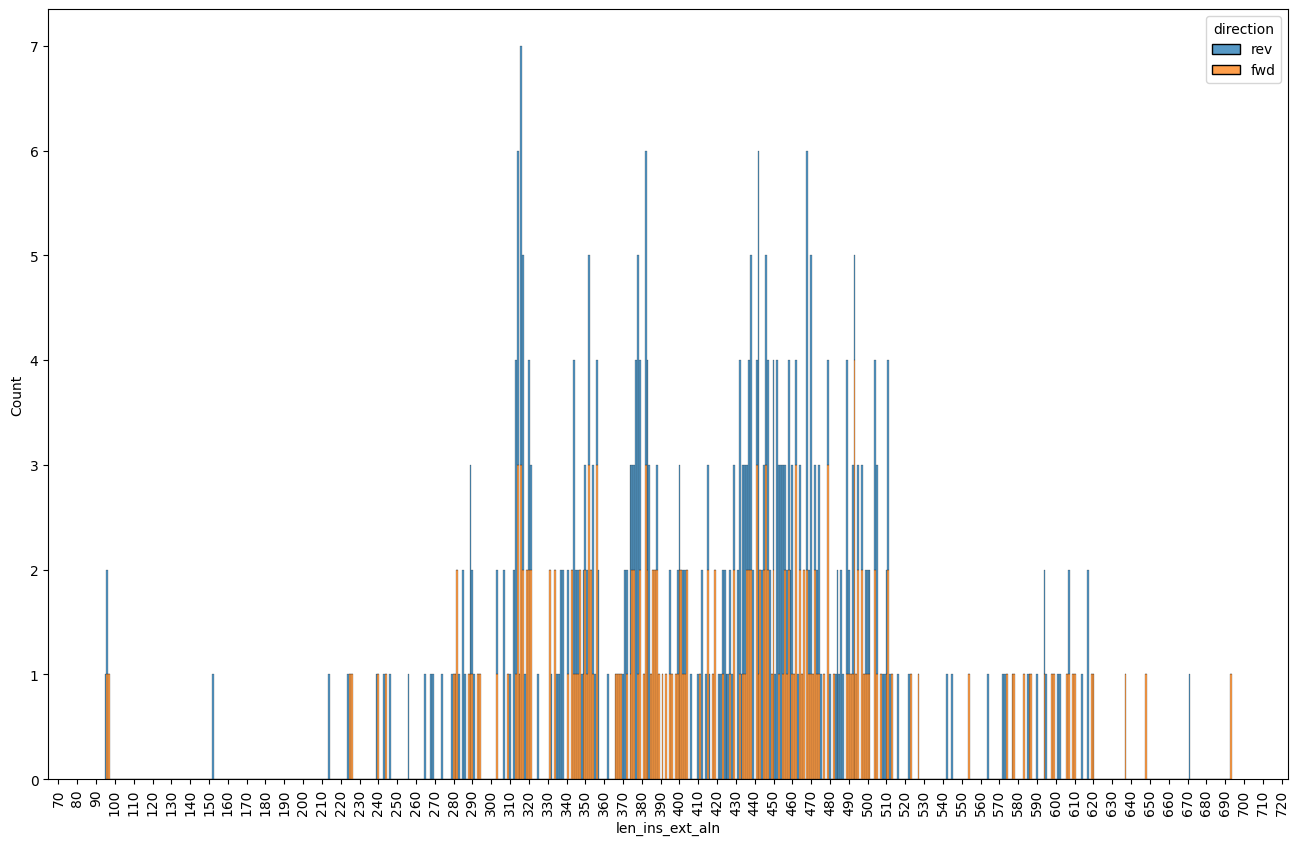

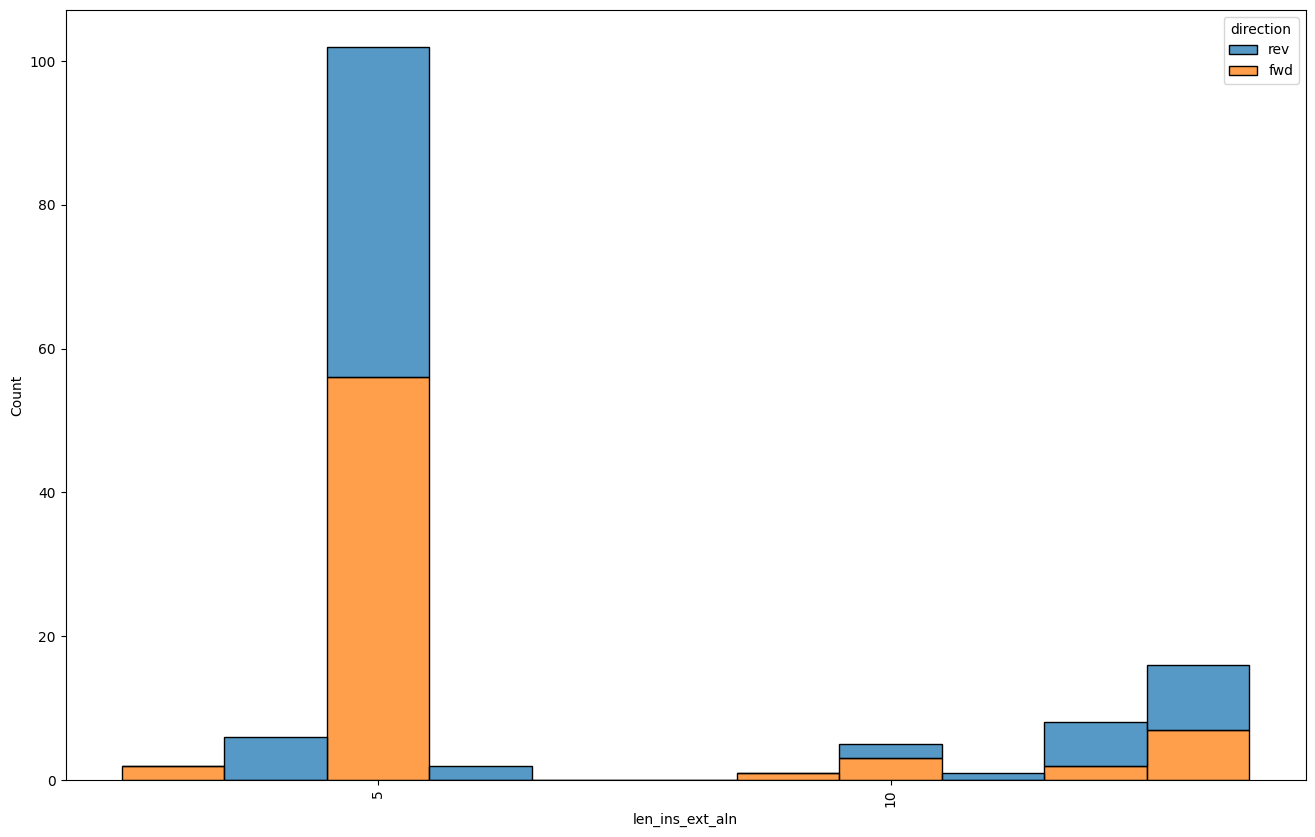

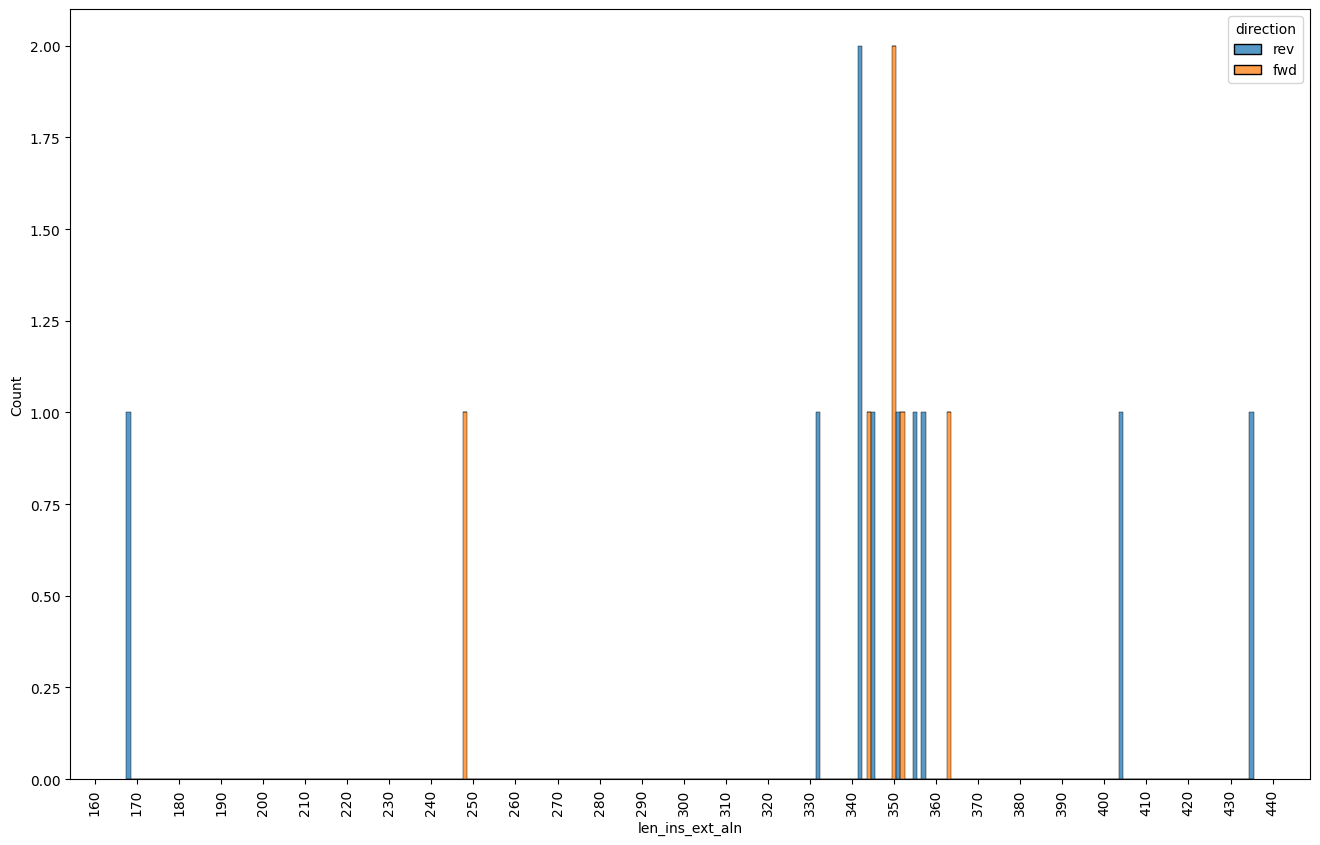

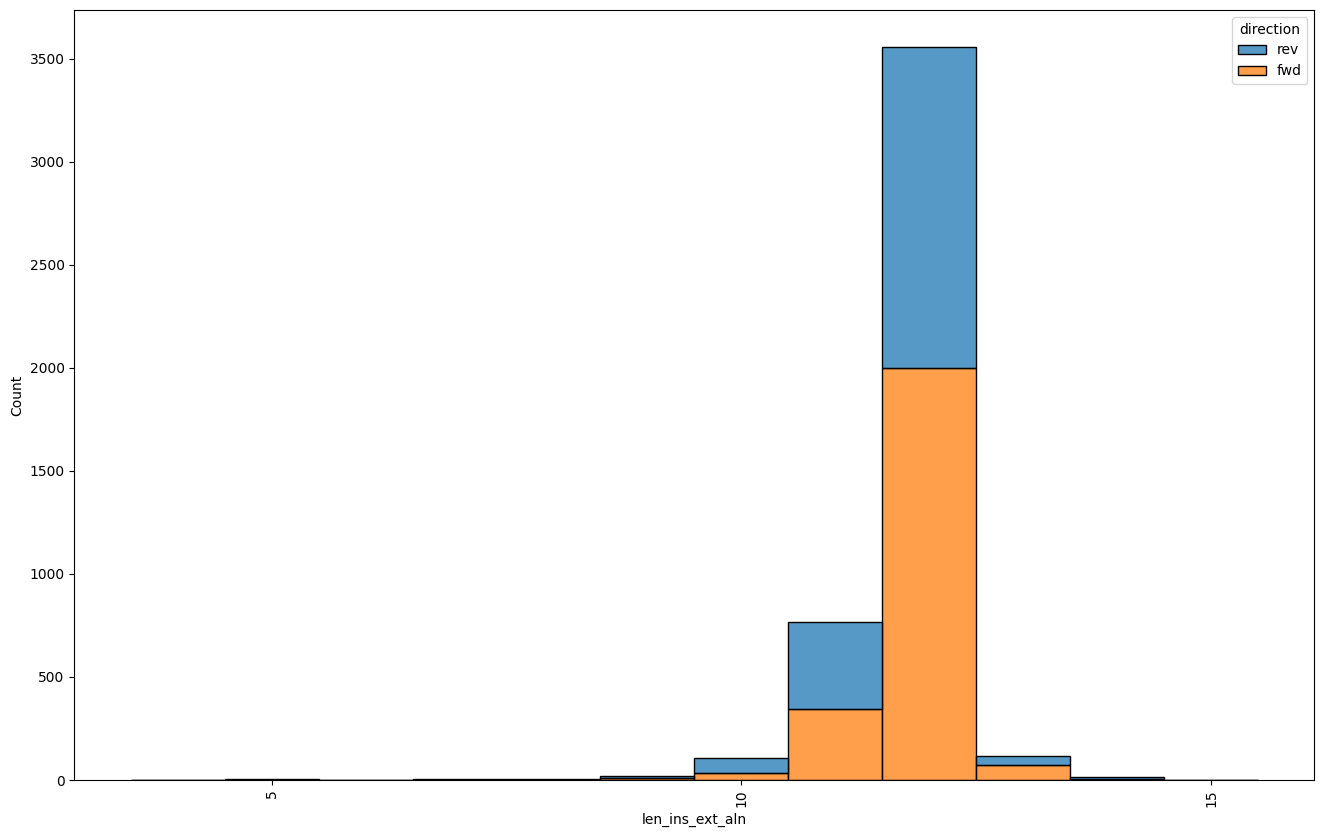

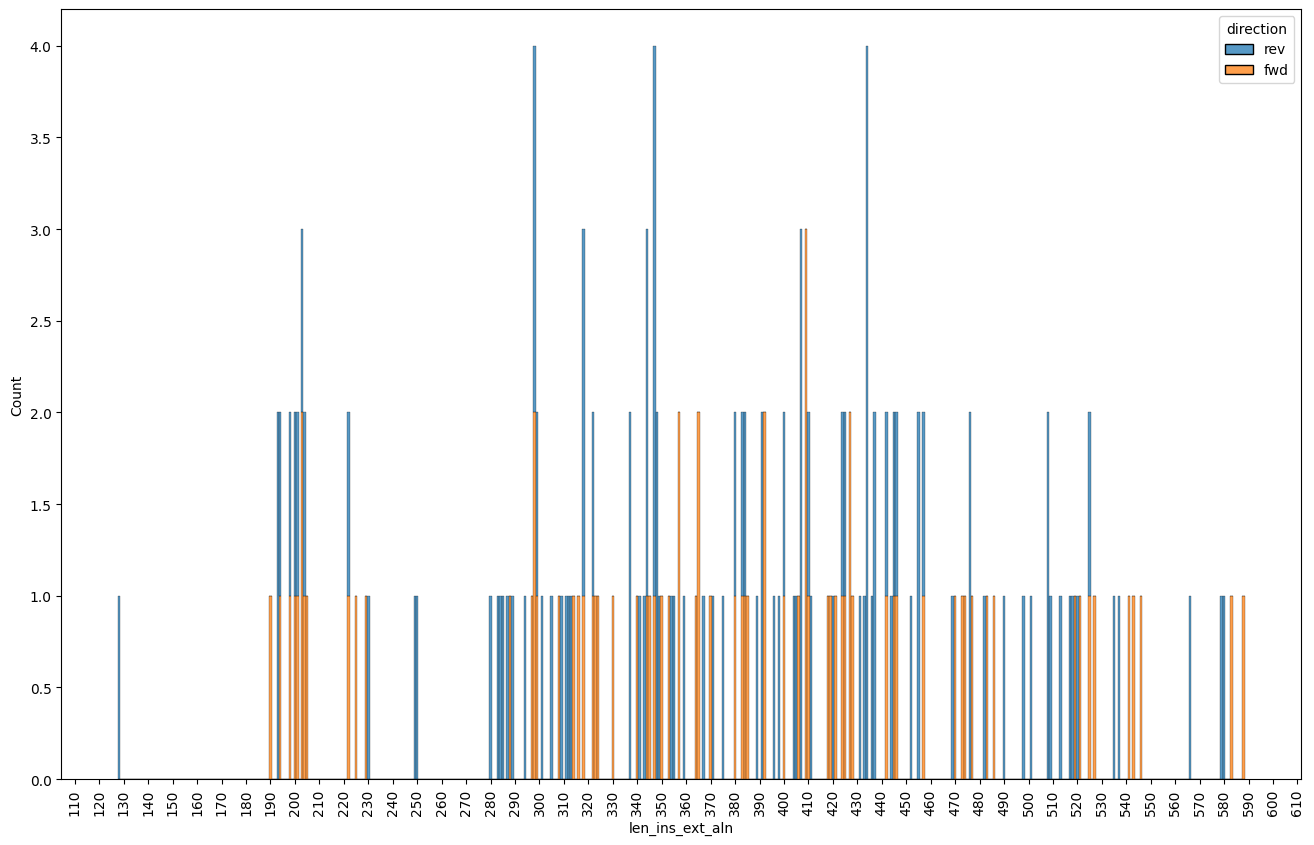

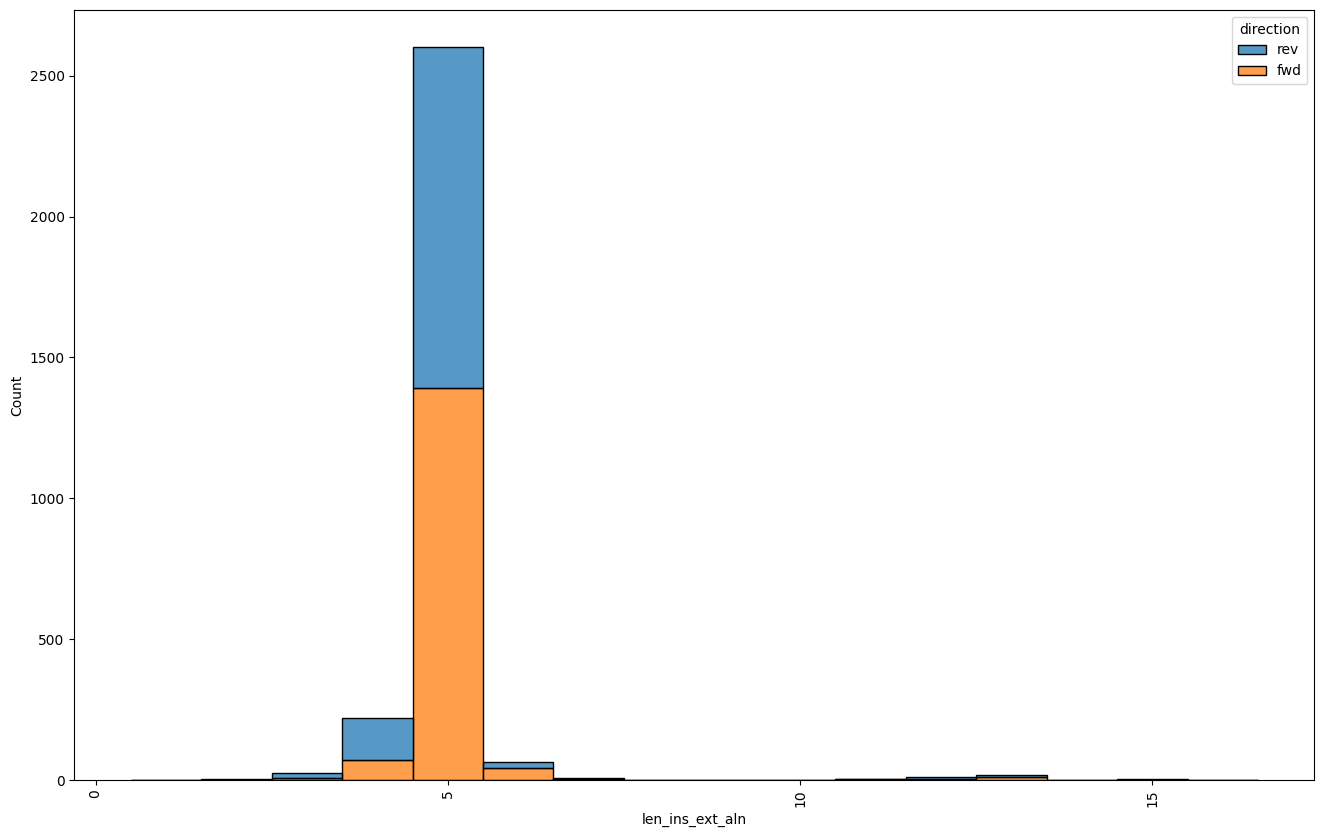

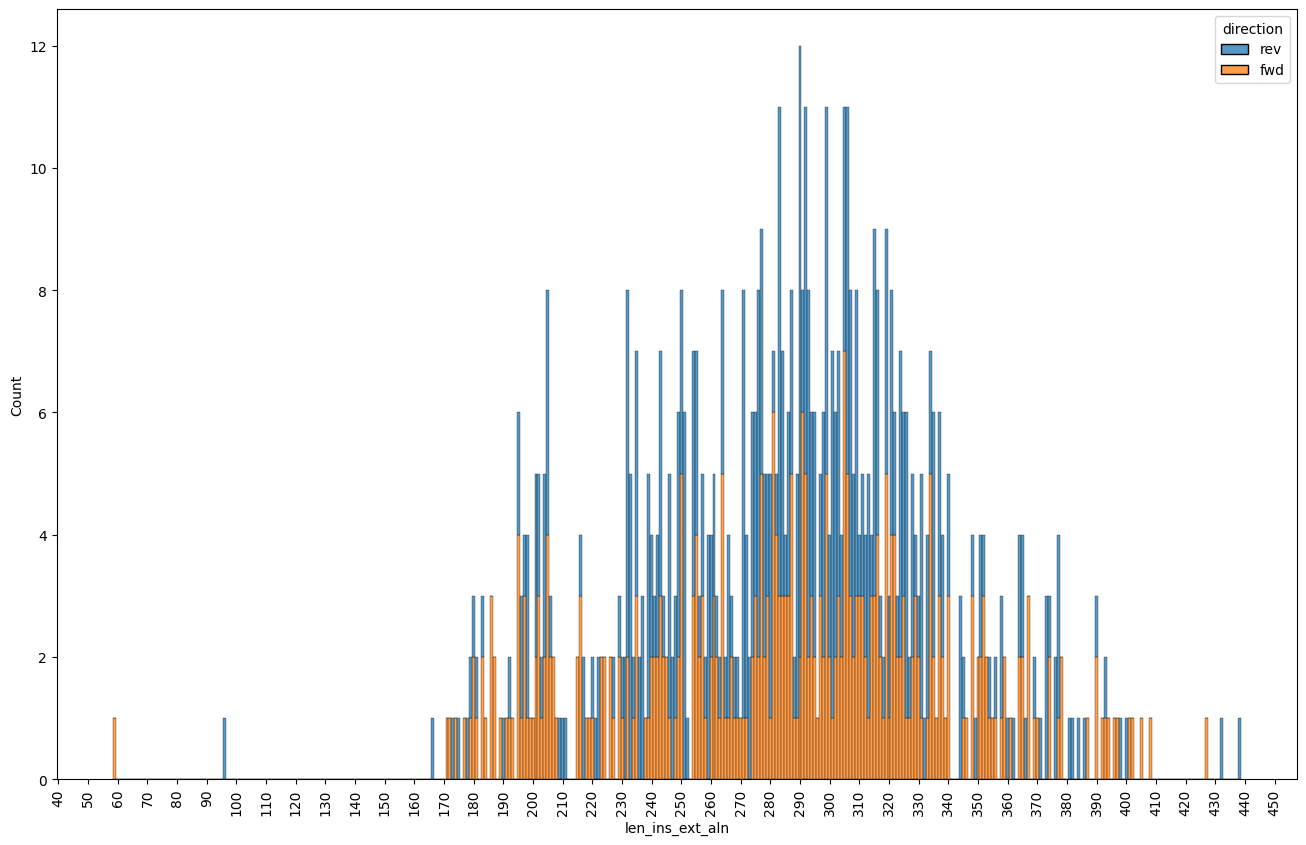

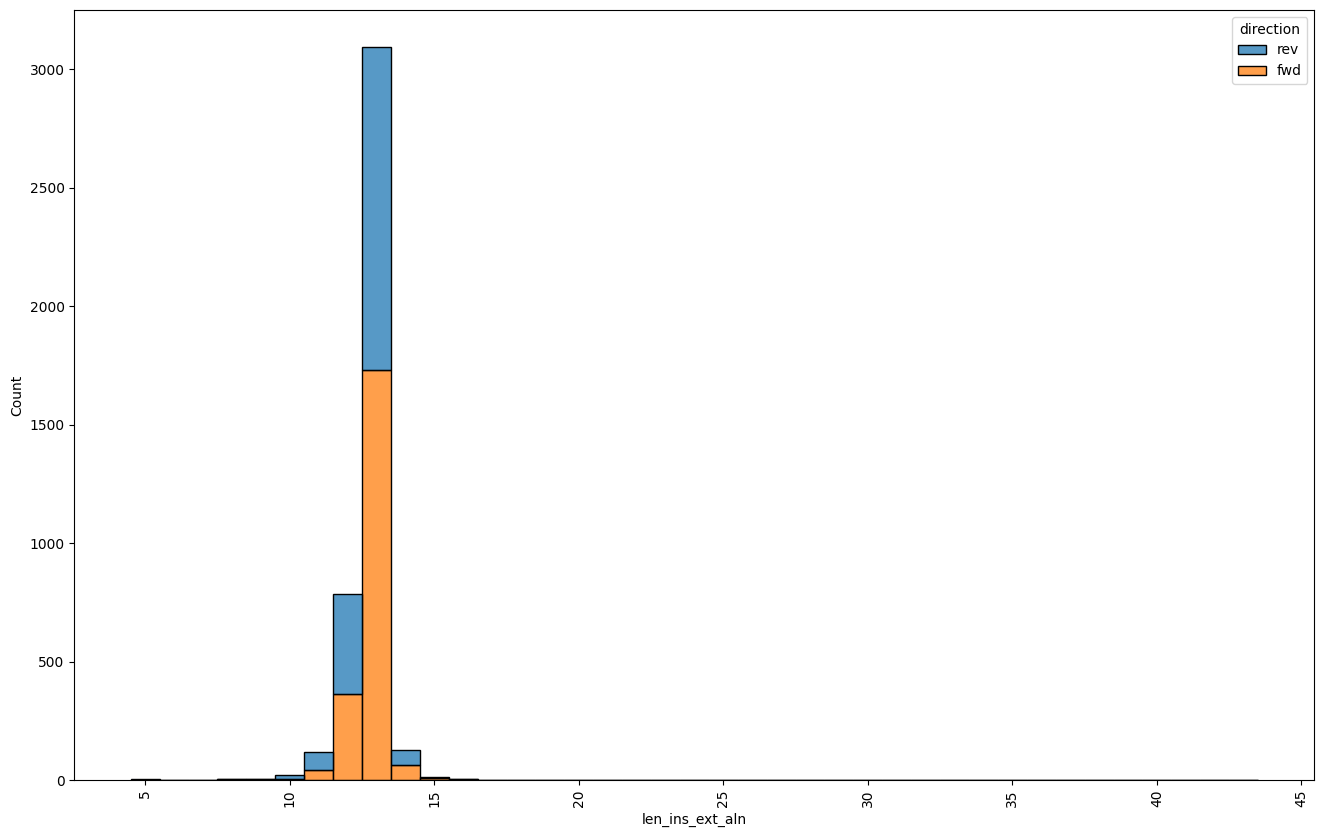

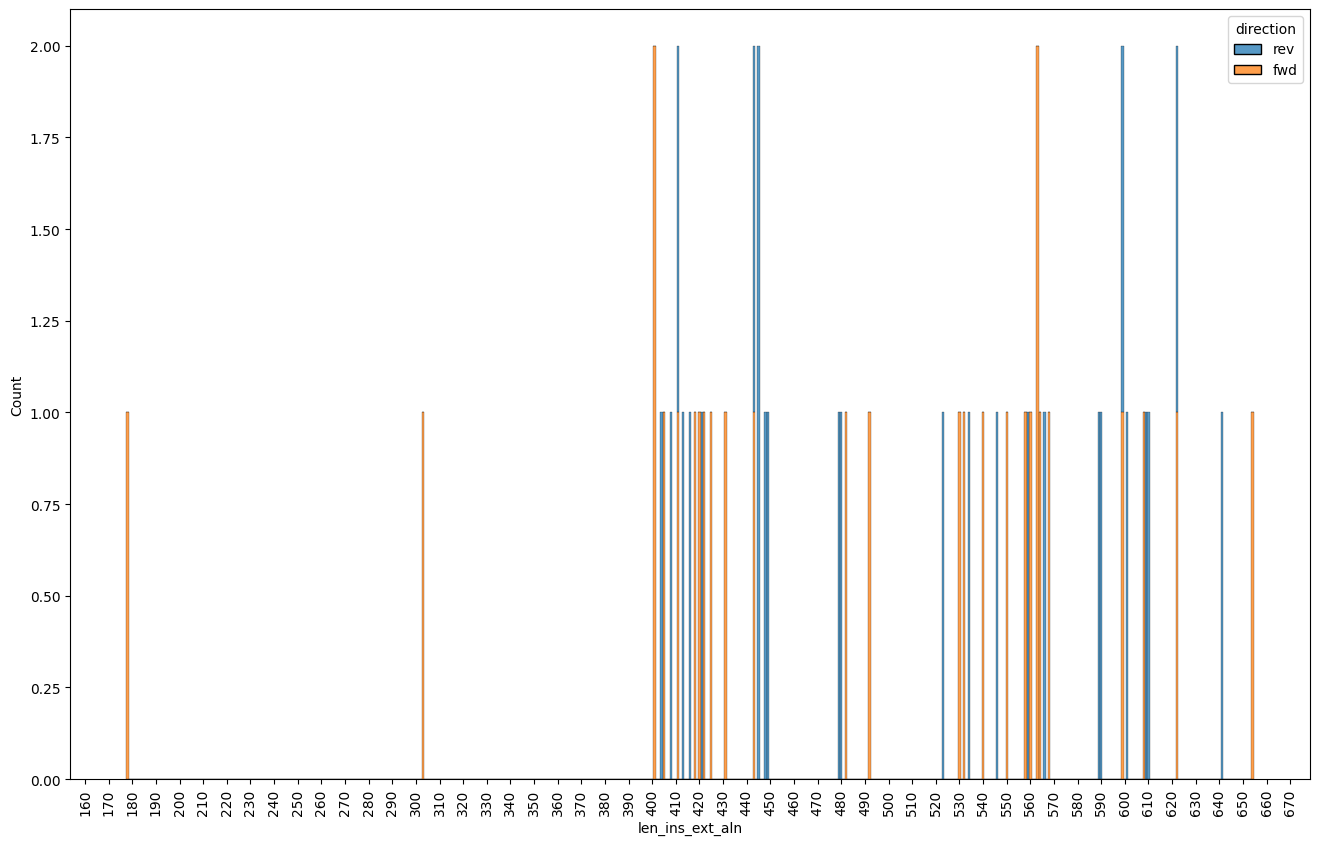

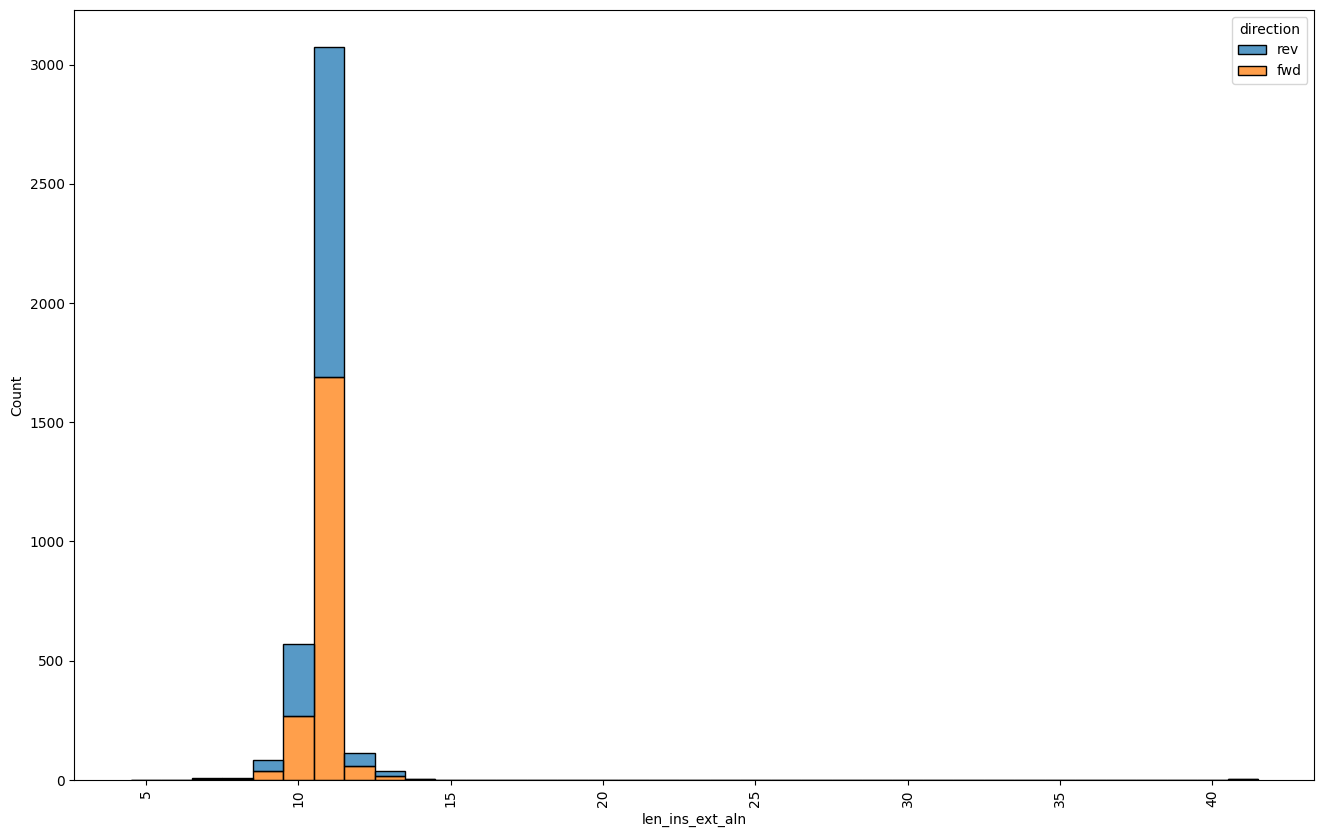

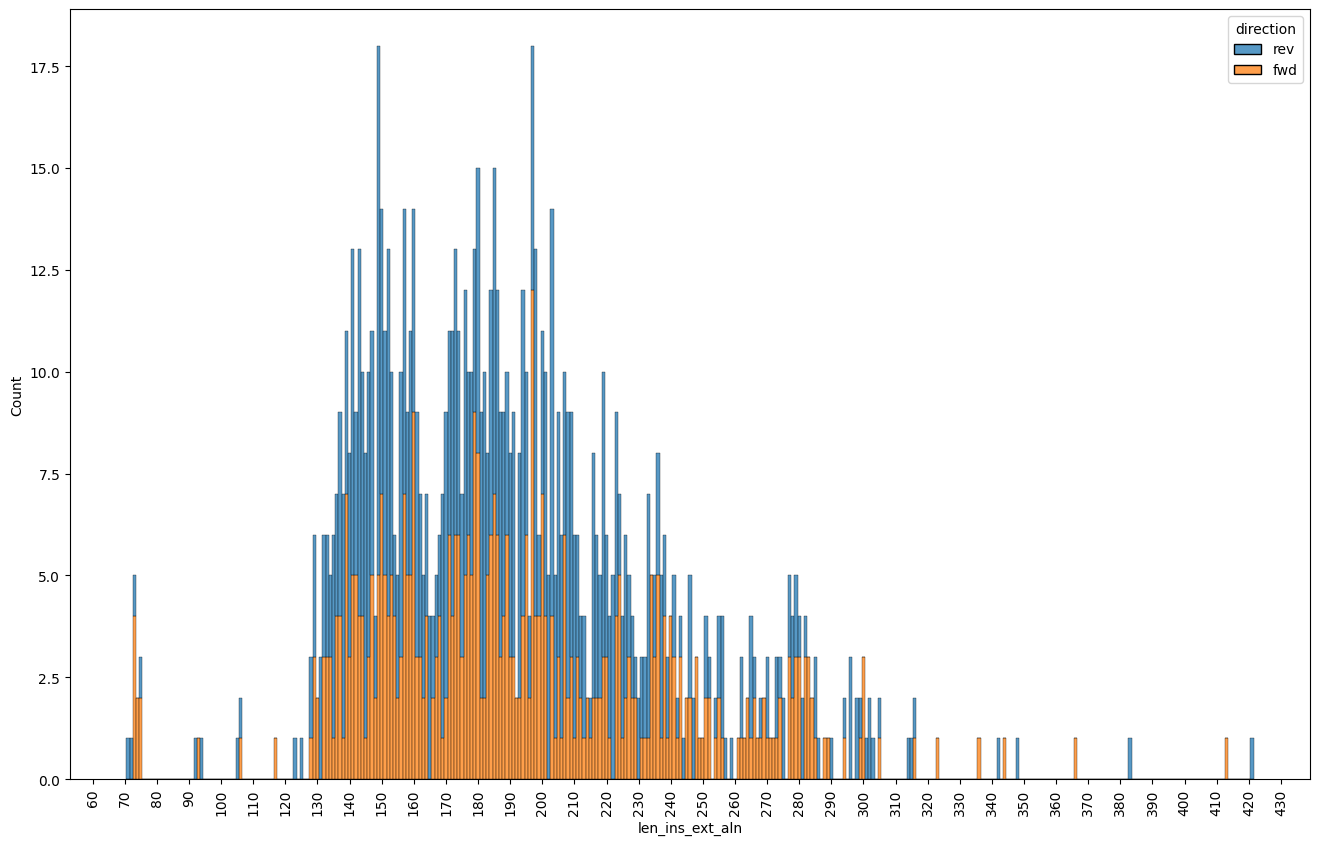

In [16]:
callers = [
    # 'dorado',
    'guppy',    
]

datasets = [
    # 'bc3_01',
    # 'bc3_02',
    # 'bc3_03',
    # 'bc6_05',
    # 'bc6_06',
    # 'bc6_07',
    # 'bc6_08',
    # 'bc6_09',
    # 'bc6_10',
    'bc6_2_05',
    'bc6_2_06',
    'bc6_2_07',
    'bc6_2_08',
    'bc6_2_09',
    'bc6_2_10',
    # 'bc7_1_18',
    # 'bc7_1_19',
    # 'bc7_1_20',
    # 'bc7_1_21',
    # 'bc7_1_22',
    # 'bc7_1_23',
    # 'bc7_1_24',
    # 'bc7_2_18',
    # 'bc7_2_19',
    # 'bc7_2_20',
    # 'bc7_2_21',
    # 'bc7_2_22',
    # 'bc7_2_23',
    # 'bc7_2_24',
    # 'sca8_1_11',
    # 'sca8_1_12',
    # 'sca8_1_15',
    # 'sca8_1_16',
    # 'sca8_1_19',
    # 'sca8_1_20',
    # 'sca8_2_11',
    # 'sca8_2_12',
    # 'sca8_2_15',
    # 'sca8_2_16',
    # 'sca8_2_19',
    # 'sca8_2_20',
]
for caller in callers:
    for dataset in datasets:
        plot(dataset, caller)
        plot_waterfalls(dataset, caller)

In [ ]:
'BLABLA'.split('CAG')